# E-commerce site clients segmentation

# Content
- [Context of the problem](#Context-of-the-problem)
- [Pre-exploratory stage: General analysis and discovery of the files](#Pre-exploratory-stage:-General-analysis-and-discovery-of-the-files)
- [Selection of variables to use in our analysis](#Selection-of-variables-to-use-in-our-analysis)
- [Exploratory analysis and data cleaning](#Exploratory-analysis-and-data-cleaning)
- [Merge of tables by keys](#Merge-of-tables-by-keys)
- [Feature engineering](#Feature-engineering)
- [Visualization of some of the indicators](#Visualization-of-some-of-the-indicators)
- [Base for the cluster maintenance analysis in time](#Base-for-the-cluster-maintenance-analysis-in-time)
- [Pickling dataframe](#Pickling-dataframe)

## Context of the problem

* Olist wants us to provide to their e-commerce teams information about customer segmentation that they can use for their daily communication campaigns.

* Our goal is to understand the different types of users through their behavior and personal data. We need to provide the marketing team an actionable description of the customer segmentation and the underlying logic for optimal use, as well as a maintenance contract proposal based on an analysis of segment stability over time.

* Olist provides an anonymized database containing information on order history, products purchased, satisfaction comments, and customer location since January 2017.

* The mission is to help Olist teams understand the different types of users. We will therefore use unsupervised methods to group customers with similar profiles. These categories can be used by the Marketing team to better communicate.

*  **Olist internal dashboards suggest that only 3% of customers in the data have made several orders. The data available will be sufficient to perform a first clustering.**

* The proposed segmentation must be easy to use by Olist Marketing team. It must be able to differentiate between good and less good customers in terms of orders and satisfaction. Olist expect segmentation on all customers as well.

* **Once the segmentation model has been chosen, Olist would like us to recommend how often the segmentation should be updated to remain relevant, in order to be able to quote a maintenance contract.**


This dataset was provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.

See more on our website: https://olist.com/pt-br/

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

Attention:
* An order might have multiple items.
* Each item might be fulfilled by a distinct seller.
* All text identifying stores and partners where replaced by the names of Game of Thrones great houses.

https://www.kaggle.com/olistbr/brazilian-ecommerce

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn style defaults and set the default figure size
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 6)})

### Dataset organization

The database is divided in multiple datasets for better understanding and organization.

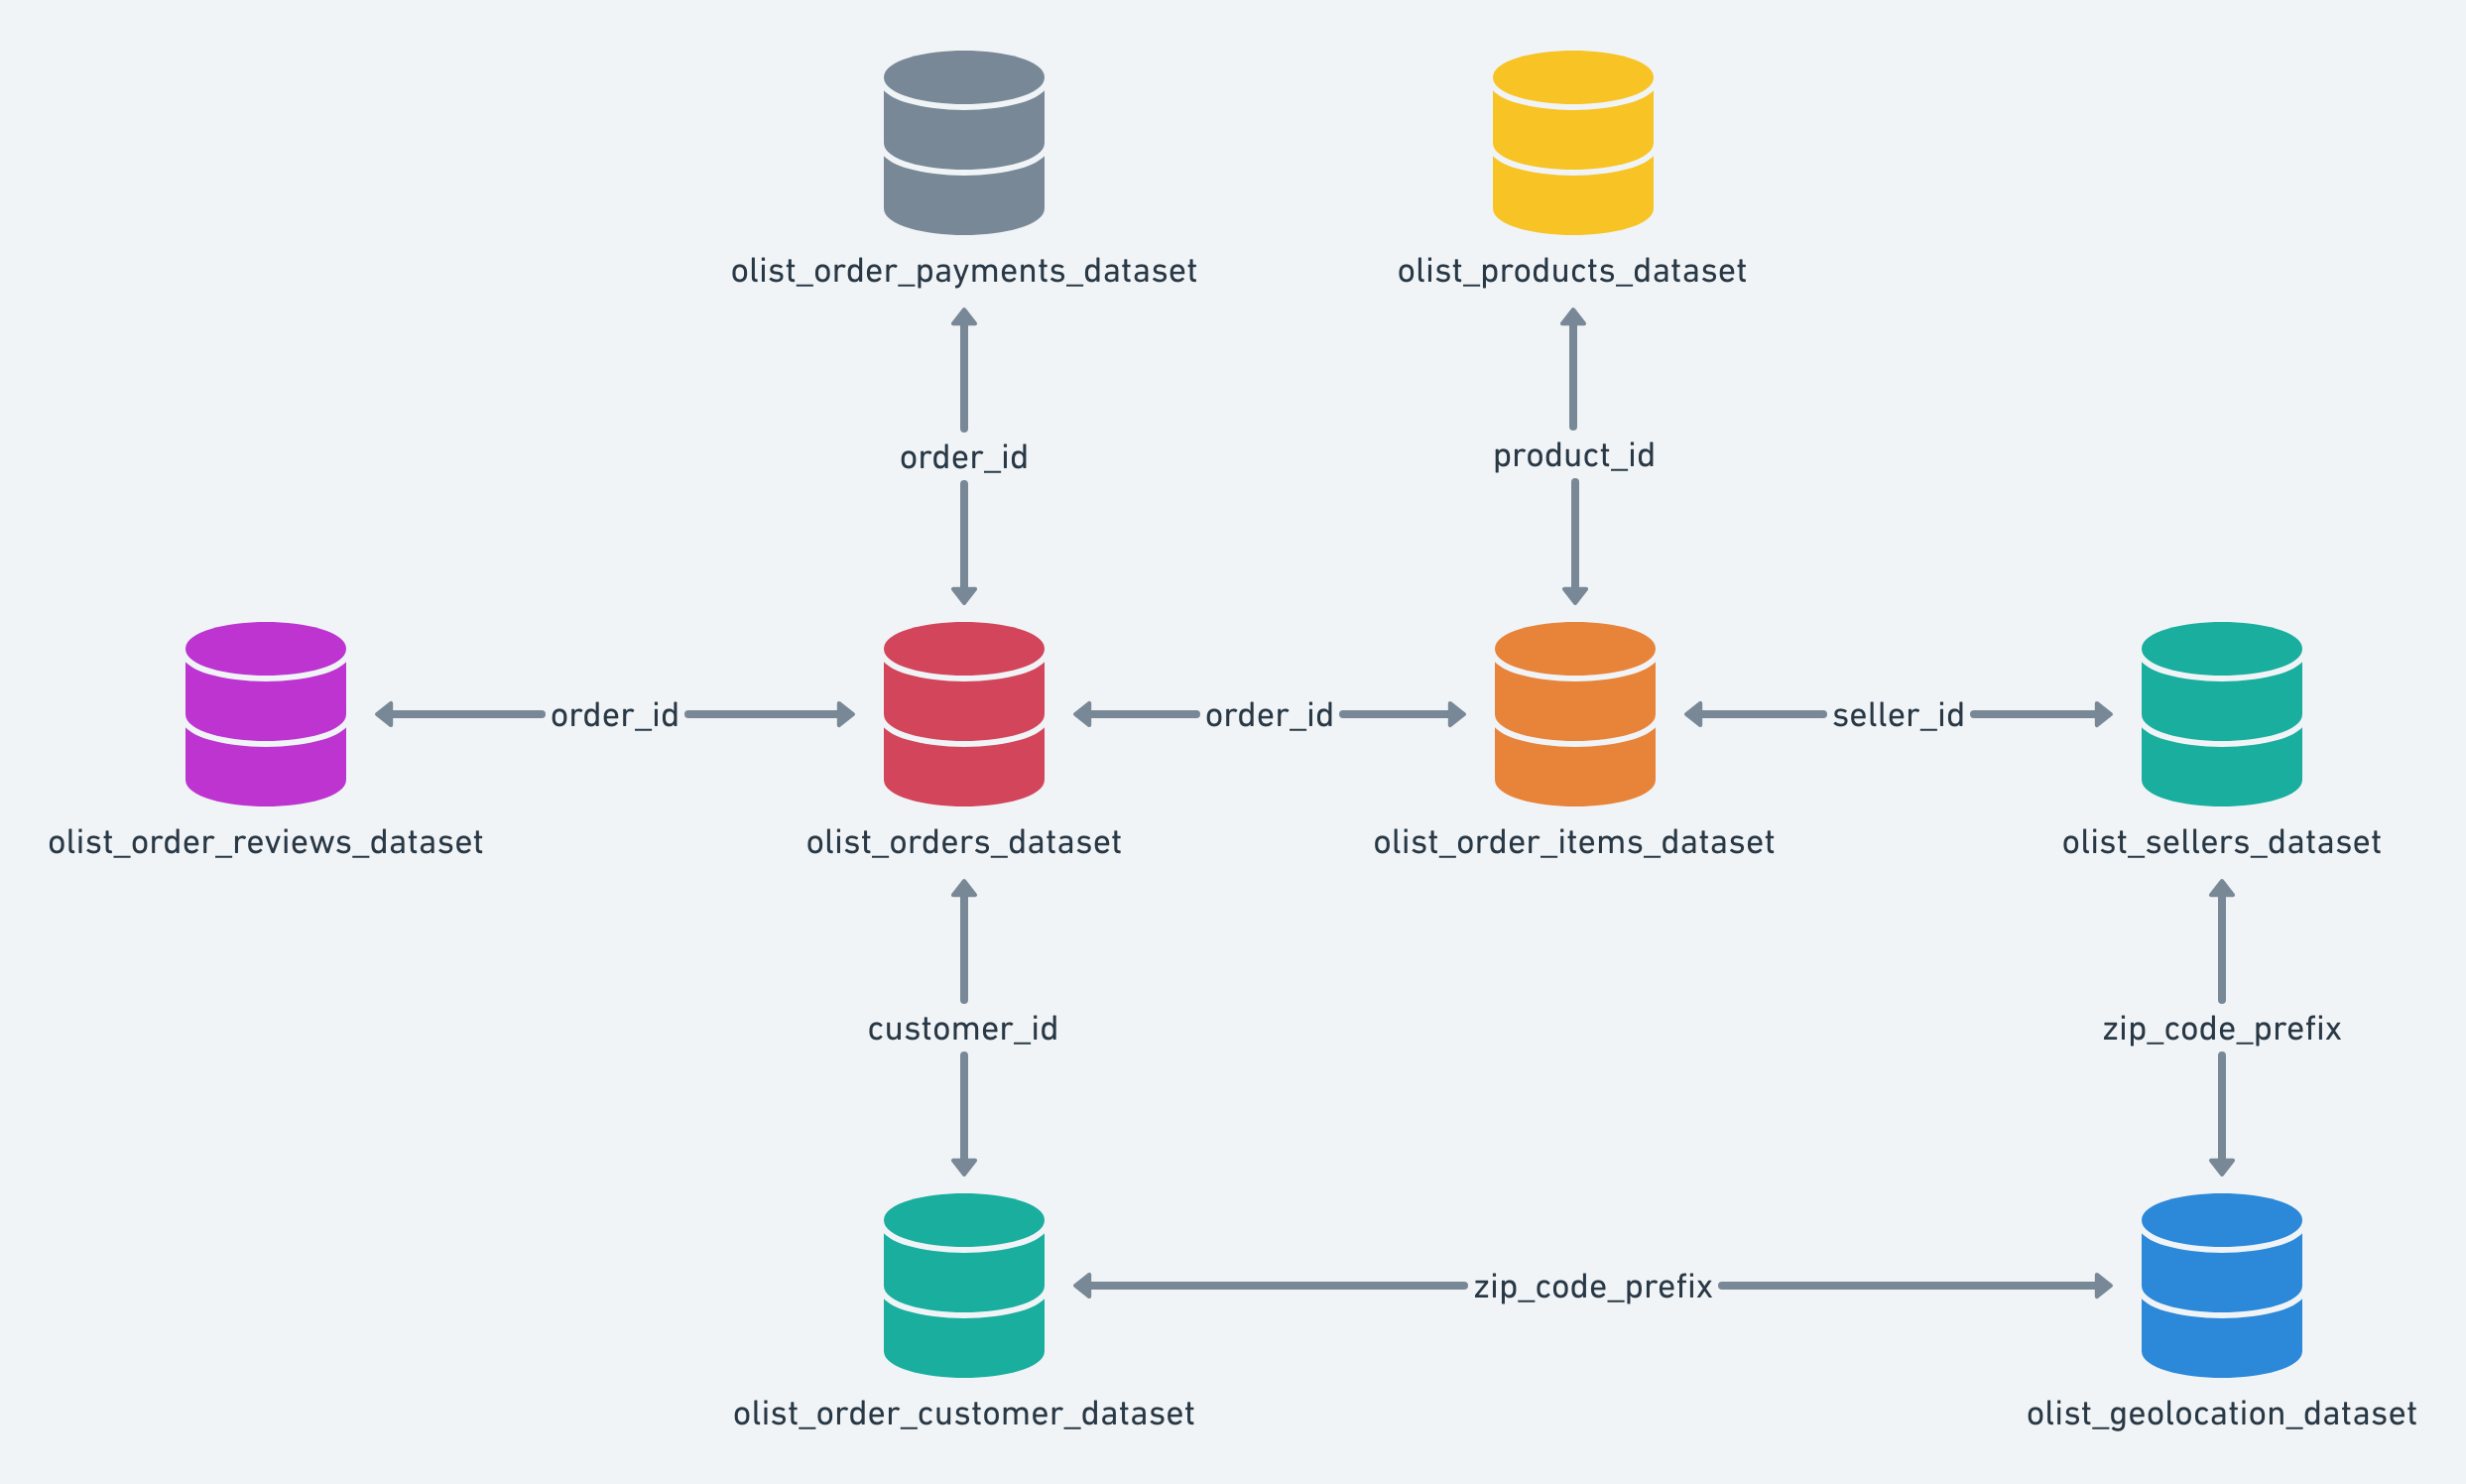

In [2]:
%matplotlib inline
from IPython.display import Image
Image('HRhd2Y0.png')

## Pre-exploratory stage: General analysis and discovery of the files

### Olist customer data file

In [3]:
olist_customers_df = pd.read_csv('olist_customers_dataset.csv')
olist_customers_df.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP

The customers dataset contains:
* **customer_id:** key to the orders dataset. Each order has a unique customer_id.
* **customer_unique_id**: unique identifier of a customer.

It also contains information about the customer: 
* **zip code, city and state.**

### Olist geolocation data file

In [4]:
olist_geolocation_df = pd.read_csv('olist_geolocation_dataset.csv')
olist_geolocation_df.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   
2                         1046       -23.546129       -46.642951   
3                         1041       -23.544392       -46.639499   
4                         1035       -23.541578       -46.641607   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
2        sao paulo                SP  
3        sao paulo                SP  
4        sao paulo                SP

The geolocation dataset contains information about geographical coordinates of a determined city.

### Olist order items data file

In [5]:
olist_order_items_df = pd.read_csv('olist_order_items_dataset.csv')
olist_order_items_df.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value  
0  2017-09-19 09:45:35   58.90          13.29  
1  2017-05-03 11:05:13  239.90          19.93  
2  2018-01-18 14:48:30  199.00          17.87  
3  2018-08-15 10:10:18   12.99          12.79  
4  2017-02-13 13:57:51  199.90          18.14

The order items dataset contains information about orders, such as:
* The **order unique identifier**, 
* The **product unique identifier**, 
* The **seller unique identifier**, 
* The **shipping date**, 
* **price per item** and, 
* **freight value per item**. 

If an order has more than one item the freight value is splitted between items. 

The order_id = 00143d0f86d6fbd9f9b38ab440ac16f5 has 3 items (same or different products). Each item has the freight calculated accordingly to its measures and weight. To get the total freight value for each order you just have to sum.

* The total order_item value is: 21.33 * 3 = 63.99

* The total freight value is: 15.10 * 3 = 45.30

* The total order value (freight + product) is: 45.30 + 63.99 = 109.29

See reference and data documentation: https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv

The previously indicated can be useful for performing feature engineering.

The 'order_item_id' is a sequential number that indicates the number of items included in the same order.

In [6]:
olist_order_items_df[olist_order_items_df['order_id'] == '00143d0f86d6fbd9f9b38ab440ac16f5']

order_id  order_item_id  \
32  00143d0f86d6fbd9f9b38ab440ac16f5              1   
33  00143d0f86d6fbd9f9b38ab440ac16f5              2   
34  00143d0f86d6fbd9f9b38ab440ac16f5              3   

                          product_id                         seller_id  \
32  e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
33  e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   
34  e95ee6822b66ac6058e2e4aff656071a  a17f621c590ea0fab3d5d883e1630ec6   

    shipping_limit_date  price  freight_value  
32  2017-10-20 16:07:52  21.33           15.1  
33  2017-10-20 16:07:52  21.33           15.1  
34  2017-10-20 16:07:52  21.33           15.1

In [7]:
olist_order_items_df[olist_order_items_df['order_id'] == '62073ec6b54b8e6322037fc0f3591ad3']

order_id  order_item_id  \
43082  62073ec6b54b8e6322037fc0f3591ad3              1   
43083  62073ec6b54b8e6322037fc0f3591ad3              2   
43084  62073ec6b54b8e6322037fc0f3591ad3              3   
43085  62073ec6b54b8e6322037fc0f3591ad3              4   
43086  62073ec6b54b8e6322037fc0f3591ad3              5   
43087  62073ec6b54b8e6322037fc0f3591ad3              6   
43088  62073ec6b54b8e6322037fc0f3591ad3              7   

                             product_id                         seller_id  \
43082  1eba879220bd0981a0e2fbab499ed4e1  5058e8c1e82653974541e83690655b4a   
43083  8ed094bfe076c568f6bb10feada3f75d  7c67e1448b00f6e969d365cea6b010ab   
43084  1eba879220bd0981a0e2fbab499ed4e1  5058e8c1e82653974541e83690655b4a   
43085  8ed094bfe076c568f6bb10feada3f75d  7c67e1448b00f6e969d365cea6b010ab   
43086  1eba879220bd0981a0e2fbab499ed4e1  5058e8c1e82653974541e83690655b4a   
43087  8ed094bfe076c568f6bb10feada3f75d  7c67e1448b00f6e969d365cea6b010ab   
43088  1eba879220bd0981a0e2fbab499ed4e1  5058e8c1e82653974541e83690655b4a   

       shipping_limit_date   price  freight_value  
43082  2018-04-23 20:29:09   79.99          13.73  
43083  2018-04-17 20:29:09  179.90         133.85  
43084  2018-04-23 20:29:09   79.99          13.73  
43085  2018-04-17 20:29:09  179.90         133.85  
43086  2018-04-23 20:29:09   79.99          13.73  
43087  2018-04-17 20:29:09  179.90         133.85  
43088  2018-04-23 20:29:09   79.99          13.73

### Olist order payments data file

In [8]:
olist_order_payments_df = pd.read_csv('olist_order_payments_dataset.csv')
olist_order_payments_df.head()

order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   
2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1  credit_card   
3  ba78997921bbcdc1373bb41e913ab953                   1  credit_card   
4  42fdf880ba16b47b59251dd489d4441a                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
2                     1          65.71  
3                     8         107.78  
4                     2         128.45

The order payments dataset includes data about the orders payment options. It contains: 
* The **order unique identifier**,  
* The **payment method or type** chosen by the customer, 
* **payment sequential** indicates when a customer may pay an order with more than one payment method. If he does so, a sequence will be created to accommodate all payments, 
* **payment or transaction value** and, 
* **payment installments** chosen by the customer.

### Olist order reviews data file

In [9]:
olist_order_reviews_df = pd.read_csv('olist_order_reviews_dataset.csv')
olist_order_reviews_df.head()

review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   
2  228ce5500dc1d8e020d8d1322874b6f0  f9e4b658b201a9f2ecdecbb34bed034b   
3  e64fb393e7b32834bb789ff8bb30750e  658677c97b385a9be170737859d3511b   
4  f7c4243c7fe1938f181bec41a392bdeb  8e6bfb81e283fa7e4f11123a3fb894f1   

   review_score review_comment_title  \
0             4                  NaN   
1             5                  NaN   
2             5                  NaN   
3             5                  NaN   
4             5                  NaN   

                              review_comment_message review_creation_date  \
0                                                NaN  2018-01-18 00:00:00   
1                                                NaN  2018-03-10 00:00:00   
2                                                NaN  2018-02-17 00:00:00   
3              Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4  Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   

  review_answer_timestamp  
0     2018-01-18 21:46:59  
1     2018-03-11 03:05:13  
2     2018-02-18 14:36:24  
3     2017-04-21 22:02:06  
4     2018-03-02 10:26:53

The order reviews dataset contains information about: 
* The **order unique identifier**, 
* **review unique identifier**, 
* **review score** which is a score ranging from 1 to 5 given by the customer on a satisfaction survey, 
* **review title and review comment** which is left by the customer in Portuguese, 
* **creation date** that shows the date in which the satisfaction survey was sent to the customer and, 
* the **review answer timestamp** that shows satisfaction survey answer timestamp.

### Olist orders data file

In [10]:
olist_orders_df = pd.read_csv('olist_orders_dataset.csv')
olist_orders_df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   
3          2017-11-22 13:39:59           2017-12-02 00:28:42   
4          2018-02-14 19:46:34           2018-02-16 18:17:02   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  
3           2017-12-15 00:00:00  
4           2018-02-26 00:00:00

The orders dataset contains: 
* The **order unique identifier**, 
* the **customer unique identifier** that is the key to the customer dataset (each order has a unique customer identifier), 
* the **order status** (delivered, shipped, etc), 
* the **order purchase timestamp** that shows the purchase timestamp, 
* the **order approval timestamp** that shows the payment approval timestamp,
* the **order delivered carrier date** that shows the order posting timestamp. When it was handled to the logistic partner,
* the **order delivered customer date** that shows the actual order delivery date to the customer and,
* the **estimated delivery date of the order** that shows the estimated delivery date that was informed to customer at the purchase moment.

### Olist products data file

In [11]:
olist_products_df = pd.read_csv('olist_products_dataset.csv')
olist_products_df.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

The product dataset contains information about the **product unique identifier** and product description.

### Olist sellers data file

In [12]:
olist_sellers_df = pd.read_csv('olist_sellers_dataset.csv')
olist_sellers_df.head()

seller_id  seller_zip_code_prefix  \
0  3442f8959a84dea7ee197c632cb2df15                   13023   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   

         seller_city seller_state  
0           campinas           SP  
1         mogi guacu           SP  
2     rio de janeiro           RJ  
3          sao paulo           SP  
4  braganca paulista           SP

The sellers dataset contains the sellers information such as: 
* **seller unique id** and 
* **sellers geographical location**.

### Olist product category name translation in english data file

In [13]:
product_category_name_translation_df = pd.read_csv('product_category_name_translation.csv')
product_category_name_translation_df.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

The products category dataset contains: 
* The **product category name** in portuguese and 
* **product category name translated** in english. 

### Number of columns, rows, and the number of missing values

Part of the files discovery is their number of columns and rows, and the number of missing values.

In [14]:
list_data_files = [
            'olist_customers_dataset',
            'olist_geolocation_dataset',
            'olist_order_items_dataset', 
            'olist_order_payments_dataset',
            'olist_order_reviews_dataset',
            'olist_orders_dataset',
            'olist_products_dataset',
            'olist_sellers_dataset',
            'product_category_name_translation'
            ]

list_data_frames = [
            olist_customers_df,
            olist_geolocation_df,
            olist_order_items_df, 
            olist_order_payments_df,
            olist_order_reviews_df,
            olist_orders_df,
            olist_products_df,
            olist_sellers_df,
            product_category_name_translation_df
            ]
                    

In [15]:
for datafile, df in zip(list_data_files, list_data_frames):
    print("The {} file contains: {} rows and {} columns".format(datafile, df.shape[0], df.shape[1]))
    print("Missing or nan values of:\n{}".format(df.isna().sum(axis=0)))
 

The olist_customers_dataset file contains: 99441 rows and 5 columns
Missing or nan values of:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
The olist_geolocation_dataset file contains: 1000163 rows and 5 columns
Missing or nan values of:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64
The olist_order_items_dataset file contains: 112650 rows and 7 columns
Missing or nan values of:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
The olist_order_payments_dataset file contains: 103886 rows and 5 columns
Missing or nan values of:
order_id                0
payment_sequential      0
payment_type            0
paym

## Selection of variables to use in our analysis

We will select the variables for our analysis. Those include the keys 

From the customers dataset we will keep:
* **customer_id**, which is the key to the orders datasets.
* **customer_unique_id**, unique identifier of a customer. It is important to remark that a customer_unique_id can have several customer_id values. The reason is that in Olist's system, each order is assigned to a customer_unique_id. This means that the same customer will get different ids (customer_id) for different orders. The purpose of having a customer_unique_id on the dataset is to allow to identify customers that made purchases several times.
See reference in: https://www.kaggle.com/olistbr/brazilian-ecommerce
* **customer_zip_code_prefix**.
* **customer_city**.
* **customer_state**.

From the customers geolocation dataset we will keep:
* **geolocation_zip_code_prefix**. 
* **geolocation_lat**.
* **geolocation_lng**.

From the order items dataset we will keep:
* **order_item_id**.
* **order_id**. 
* **product_id**. 

From the order payments dataset we will keep:
* **order_id**.
* **payment_type**.
* **payment_value**.

From the order reviews dataset we will keep:
* **review_id**.
* **order_id**.
* **review_score**.

From the orders datset we will kepp:
* **order_id**.
* **customer_id**.
* **order_purchase_timestamp**.
* **order_delivered_customer_date**.

From the products dataset we will keep:
* **product_id**.
* **product_category_name**.

From the product category name dataset we will keep:
* **product_category_name**.
* **product_category_name_english**.

In the next cell we will eliminate the columns that we will not include for our analysis.

In [16]:
olist_geolocation_df = olist_geolocation_df.drop(columns = ['geolocation_city', 
                                                                'geolocation_state'])

olist_order_items_df = olist_order_items_df.drop(columns = ['seller_id',
                                                            'shipping_limit_date', 
                                                            'price', 
                                                            'freight_value'])

olist_order_payments_df = olist_order_payments_df.drop(columns = ['payment_sequential',
                                                                    'payment_installments'])

olist_order_reviews_df = olist_order_reviews_df.drop(columns = ['review_comment_title',
                                                                'review_comment_message', 
                                                                'review_creation_date',
                                                                'review_answer_timestamp'])

olist_orders_df = olist_orders_df.drop(columns = ['order_status',
                                                    'order_approved_at', 
                                                    'order_delivered_carrier_date',
                                                    'order_estimated_delivery_date'])

olist_products_df = olist_products_df.drop(columns = ['product_name_lenght',
                                                        'product_description_lenght', 
                                                        'product_photos_qty', 
                                                        'product_weight_g',
                                                        'product_length_cm', 
                                                        'product_height_cm', 
                                                        'product_width_cm'])

## Exploratory analysis and data cleaning

### Exploration of missing values

In order to better understand the quantity of missing values in some of the data files, we plot the percentage of them.

In [17]:
def graph_nan_values_per_column(data, size):

    nan_values = 100 * data.isna().sum() / len(data) 
    nan_values = nan_values.sort_values(ascending=False)
    nan_values = nan_values.astype(int)
    ax_nan_values = nan_values.plot(kind='barh', figsize=size, color='red')
    ax_nan_values.set_xlabel("Percentage of NaN values", fontsize='x-large')
    ax_nan_values.set_title("Percentage of NaN values \n in the data",fontsize='x-large')

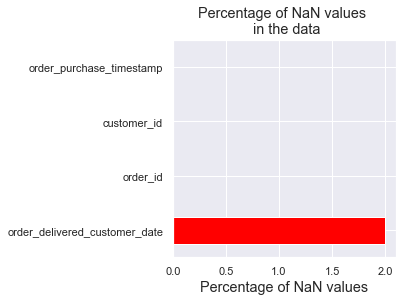

In [18]:
graph_nan_values_per_column(olist_orders_df, (4,4))

There are 2965 missing values in the variable 'order_delivered_customer_date'. We will delete them.

In [19]:
olist_orders_df = olist_orders_df.dropna(axis='rows')

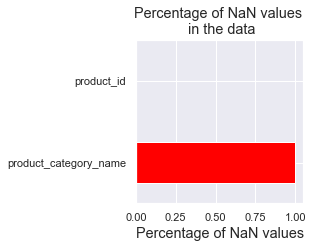

In [20]:
graph_nan_values_per_column(olist_products_df, (3,3))

There are 610 missing values in the variable 'product_category_name'. We will delete them.

In [21]:
olist_products_df = olist_products_df.dropna(axis='rows')

### Category name in english variables regroup 

In [22]:
product_category_name_translation_df['product_category_name_english'].unique()

array(['health_beauty', 'computers_accessories', 'auto', 'bed_bath_table',
       'furniture_decor', 'sports_leisure', 'perfumery', 'housewares',
       'telephony', 'watches_gifts', 'food_drink', 'baby', 'stationery',
       'tablets_printing_image', 'toys', 'fixed_telephony',
       'garden_tools', 'fashion_bags_accessories', 'small_appliances',
       'consoles_games', 'audio', 'fashion_shoes', 'cool_stuff',
       'luggage_accessories', 'air_conditioning',
       'construction_tools_construction',
       'kitchen_dining_laundry_garden_furniture',
       'costruction_tools_garden', 'fashion_male_clothing', 'pet_shop',
       'office_furniture', 'market_place', 'electronics',
       'home_appliances', 'party_supplies', 'home_confort',
       'costruction_tools_tools', 'agro_industry_and_commerce',
       'furniture_mattress_and_upholstery', 'books_technical',
       'home_construction', 'musical_instruments',
       'furniture_living_room', 'construction_tools_lights',
       'indust

In [23]:
product_category_en = {#home
                        'furniture_living_room' : 'home',
                        'furniture_mattress_and_upholstery' : 'home',
                        'furniture_bedroom' : 'home',
                        'furniture_decor' : 'home',
                        'bed_bath_table' : 'home',
                        'kitchen_dining_laundry_garden_furniture' : 'home',
                        'la_cuisine' : 'home',
                        'home_confort' : 'home',
                        'home_comfort_2' : 'home',
                        'housewares' : 'home', 
                        #appliances
                        'small_appliances' : 'appliances',
                        'small_appliances_home_oven_and_coffee' : 'appliances',
                        'home_appliances_2' : 'appliances',
                        'home_appliances' : 'appliances',  
                        #construction
                        'construction_tools_construction': 'construction',
                        'costruction_tools_garden': 'construction',
                        'costruction_tools_tools': 'construction',
                        'construction_tools_safety': 'construction',
                        'construction_tools_lights': 'construction',
                        'home_construction': 'construction',
                        'air_conditioning': 'construction',
                        #office
                        'office_furniture' : 'office',
                        'industry_commerce_and_business' : 'office',
                        'stationery' : 'office',
                        'agro_industry_and_commerce' : 'office',
                        'signaling_and_security' : 'office',
                        'furnitures' : 'office',
                        'security_and_services' : 'office',
                        #electronics
                        'telephony' : 'electronics',
                        'electronics': 'electronics',
                        'computers_accessories': 'electronics',
                        'consoles_games': 'electronics',
                        'fixed_telephony': 'electronics',
                        'audio': 'electronics',
                        'computers': 'electronics',
                        'tablets_printing_image': 'electronics',
                        #sports_leisure
                        'sports_leisure' : 'sports_leisure',
                        #arts
                        'musical_instruments': 'arts',
                        'books' : 'arts',
                        'books_imported': 'arts',
                        'books_general_interest': 'arts',
                        'books_technical': 'arts',
                        'art': 'arts',
                        'toys': 'arts',
                        'cine_photo': 'arts',
                        'cds_dvds_musicals': 'arts',
                        'music': 'arts',
                        'dvds_blu_ray': 'arts',
                        'arts_and_craftmanship': 'arts',
                        #fashion
                        'watches_gifts' : 'fashion',
                        'luggage_accessories': 'fashion',
                        'fashion_bags_accessories' : 'fashion',
                        'fashion_underwear_beach' : 'fashion',
                        'fashion_shoes' : 'fashion', 
                        'fashion_male_clothing' : 'fashion',
                        'fashio_female_clothing' : 'fashion',
                        'fashion_sport' : 'fashion',
                        'fashion_childrens_clothes' : 'fashion',
                        #health_beauty
                        'health_beauty' : 'health_beauty', 
                        'baby': 'health_beauty',
                        'diapers_and_hygiene' : 'health_beauty',
                        'perfumery' : 'health_beauty',
                        #garden and pets
                        'flowers' : 'garden_pets',
                        'pet_shop' : 'garden_pets',
                        'garden_tools' : 'garden_pets',
                        #auto
                        'auto' : 'auto',
                        #food_drinks
                        'food_drink' : 'food_drinks',
                        'food' : 'food_drinks',
                        'drinks' : 'food_drinks',
                        #other
                        'market_place' : 'other', 
                        'cool_stuff' : 'other',
                        'party_supplies': 'other',
                        'christmas_supplies' : 'other'}

for key, value in product_category_en.items():
    product_category_name_translation_df['product_category_name_english']. \
        loc[product_category_name_translation_df["product_category_name_english"]. \
            str.contains(key, case=False, regex=False, na=False)] = value

### Exploration and treatment of duplicate values

#### olist_products_dataset 

In [24]:
print ("The number of duplicate values in the variable 'product_id' of the products dataframe is: {}"\
        .format(olist_products_df.duplicated(subset=['product_id']).sum()))

The number of duplicate values in the variable 'product_id' of the products dataframe is: 0


#### olist_order_items_dataset  

In [25]:
print ("The number of duplicate values in the variable 'order_id' of the order items dataframe is: {}"\
        .format(olist_order_items_df.duplicated(subset=['order_id']).sum()))

The number of duplicate values in the variable 'order_id' of the order items dataframe is: 13984


In [26]:
print ("The number of duplicate values in the variable 'product_id' of the order items dataframe is: {}"\
        .format(olist_order_items_df.duplicated(subset=['product_id']).sum()))

The number of duplicate values in the variable 'product_id' of the order items dataframe is: 79699


As we observed, there are duplicate values of 'product_id' and 'order_id'. This is because an order can have several products or items (also indicated in the 'order_item_id' variable), and the products are not necessarily the same for an order, as shown next.

In [27]:
olist_order_items_df[olist_order_items_df['order_item_id'] > 5]

order_id  order_item_id  \
1598    03aba68b07658f28f29612641f08d4ba              6   
1652    03caa2c082116e1d31e67e9ae3700499              6   
1653    03caa2c082116e1d31e67e9ae3700499              7   
1654    03caa2c082116e1d31e67e9ae3700499              8   
2037    04993613aee4046caf92ea17b316dcfb              6   
...                                  ...            ...   
109128  f80549a97eb203e1566e026ab66f045b              8   
109129  f80549a97eb203e1566e026ab66f045b              9   
109130  f80549a97eb203e1566e026ab66f045b             10   
109587  f91234b89ca8c758b3d2be234acb0355              6   
111255  fcbe557f2bb4cd2409d67dec35a1e6f3              6   

                              product_id  
1598    e7cc48a9daff5436f63d3aad9426f28b  
1652    5769ef0a239114ac3a854af00df129e4  
1653    5769ef0a239114ac3a854af00df129e4  
1654    5769ef0a239114ac3a854af00df129e4  
2037    078e8db43688ea060cf754e7bd2b92e7  
...                                  ...  
109128  d5991653e037ccb7af6ed7d94246b249  
109129  d5991653e037ccb7af6ed7d94246b249  
109130  d5991653e037ccb7af6ed7d94246b249  
109587  588ea3decc0d8e1d19ce6160c5b0da1b  
111255  0a9c1531aa7c17c8c64157b634fa9ba9  

[469 rows x 3 columns]

In [28]:
olist_order_items_df[olist_order_items_df['order_id'] == '62073ec6b54b8e6322037fc0f3591ad3']

order_id  order_item_id  \
43082  62073ec6b54b8e6322037fc0f3591ad3              1   
43083  62073ec6b54b8e6322037fc0f3591ad3              2   
43084  62073ec6b54b8e6322037fc0f3591ad3              3   
43085  62073ec6b54b8e6322037fc0f3591ad3              4   
43086  62073ec6b54b8e6322037fc0f3591ad3              5   
43087  62073ec6b54b8e6322037fc0f3591ad3              6   
43088  62073ec6b54b8e6322037fc0f3591ad3              7   

                             product_id  
43082  1eba879220bd0981a0e2fbab499ed4e1  
43083  8ed094bfe076c568f6bb10feada3f75d  
43084  1eba879220bd0981a0e2fbab499ed4e1  
43085  8ed094bfe076c568f6bb10feada3f75d  
43086  1eba879220bd0981a0e2fbab499ed4e1  
43087  8ed094bfe076c568f6bb10feada3f75d  
43088  1eba879220bd0981a0e2fbab499ed4e1

The previous observations will be useul to perform further operations for the creation of new variables, such as number of items purchased in an order.

#### olist_geolocation_dataset 

In [29]:
print ("The number of duplicate values in the variable 'geolocation_zip_code_prefix' of the customers geolocation dataframe is: {}"\
        .format(olist_geolocation_df.duplicated(subset=['geolocation_zip_code_prefix']).sum()))

The number of duplicate values in the variable 'geolocation_zip_code_prefix' of the customers geolocation dataframe is: 981148


In [30]:
olist_geolocation_df[olist_geolocation_df.duplicated(['geolocation_zip_code_prefix'],keep=False)]

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                               1037       -23.545621       -46.639292
1                               1046       -23.546081       -46.644820
2                               1046       -23.546129       -46.642951
3                               1041       -23.544392       -46.639499
4                               1035       -23.541578       -46.641607
...                              ...              ...              ...
1000158                        99950       -28.068639       -52.010705
1000159                        99900       -27.877125       -52.224882
1000160                        99950       -28.071855       -52.014716
1000161                        99980       -28.388932       -51.846871
1000162                        99950       -28.070104       -52.018658

[999120 rows x 3 columns]

In [31]:
olist_geolocation_df[olist_geolocation_df['geolocation_zip_code_prefix'] == 1037]

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                            1037       -23.545621       -46.639292
14                           1037       -23.545187       -46.637855
31                           1037       -23.546705       -46.640336
169                          1037       -23.543883       -46.638075
178                          1037       -23.546157       -46.639885
236                          1037       -23.543883       -46.638075
283                          1037       -23.545199       -46.637916
417                          1037       -23.545187       -46.637855
420                          1037       -23.546723       -46.640281
433                          1037       -23.546463       -46.640145
513                          1037       -23.545621       -46.639292
533                          1037       -23.545808       -46.639602
677                          1037       -23.545867       -46.639685
700                          1037       -23.544342       -46.638345
724                          1037       -23.543137       -46.637609
781                          1037       -23.543137       -46.637609
848                          1037       -23.546463       -46.640145
874                          1037       -23.544926       -46.638288
956                          1037       -23.546093       -46.639759
983                          1037       -23.545187       -46.637855
1003                         1037       -23.545199       -46.637916
1017                         1037       -23.546705       -46.640336
1050                         1037       -23.546463       -46.640145
1216                         1037       -23.546344       -46.639959
1345                         1037       -23.545187       -46.637855
1349                         1037       -23.545199       -46.637916

As we observed, we have duplicated values of the customers geolocation. Due to anonymity, we don't know the location of an specific customer. So in order to eliminate the duplicate values, we will perform a "group_by" zip_code_prefix and keep the median value of the latitude and longitude of each customer.

In [32]:
olist_geolocation_df = olist_geolocation_df.rename(columns={"geolocation_zip_code_prefix": "zip_code_prefix"})

In [33]:
grouped_df_olist_geolocation = olist_geolocation_df.copy()

In [34]:
grouped_df_olist_geolocation = grouped_df_olist_geolocation.groupby("zip_code_prefix", as_index=False).agg({"geolocation_lat": np.median,
                                                                                                                        "geolocation_lng": np.median})

grouped_df_olist_geolocation = grouped_df_olist_geolocation.rename(columns={"geolocation_lat": "customer_geolocation_latitude",
                                                                            "geolocation_lng": "customer_geolocation_longitude"})

In [35]:
grouped_df_olist_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19015 entries, 0 to 19014
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   zip_code_prefix                 19015 non-null  int64  
 1   customer_geolocation_latitude   19015 non-null  float64
 2   customer_geolocation_longitude  19015 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 445.8 KB


In [36]:
# print ("The number of duplicate values in the variable 'zip_code_prefix' of the orders dataframe is: {}"\
#         .format(grouped_df_olist_geolocation.duplicated(subset=['zip_code_prefix']).sum()))

#### olist_customers_dataset 

In [37]:
print ("The number of duplicate values in the variable 'customer_unique_id' of the customer dataframe is: {}"\
        .format(olist_customers_df.duplicated(subset=['customer_unique_id']).sum()))

The number of duplicate values in the variable 'customer_unique_id' of the customer dataframe is: 3345


In [38]:
olist_customers_df[olist_customers_df.duplicated(['customer_unique_id'],keep=False)]

customer_id                customer_unique_id  \
5      879864dab9bc3047522c92c82e1212b8  4c93744516667ad3b8f1fb645a3116a4   
8      5adf08e34b2e993982a47070956c5c65  1175e95fb47ddff9de6b2b06188f7e0d   
13     eabebad39a88bb6f5b52376faec28612  295c05e81917928d76245e842748184d   
32     2d5831cb2dff7cdefba62e950ae3dc7b  e9dd12dca17352644a959d9dea133935   
33     b2bed119388167a954382cca36c4777f  e079b18794454de9d2be5c12b4392294   
...                                 ...                               ...   
99324  5b46a0d983eec8c97363bea78d4a69dd  8bab3162259edfaadd1ea2e1fe7f58dc   
99327  c1affa46f9f3b514555259049a0307b9  12ab9334b1240d6d037f2b0102a49571   
99336  ebf46ff530343a129926adc1f831dea4  0ee57f62666561b72f2ceacad0230cbf   
99353  282fbce48e4d2077aad602dd125c9225  0ceb502fc33a2ad327b08288c5310e2e   
99406  d9110683c7a282144e9fc97660026a28  5cbfdb85ec130898108b32c50d619c39   

       customer_zip_code_prefix         customer_city customer_state  
5                         89254        jaragua do sul             SC  
8                         81560              curitiba             PR  
13                         5704             sao paulo             SP  
32                        42800              camacari             BA  
33                        27525               resende             RJ  
...                         ...                   ...            ...  
99324                     31565        belo horizonte             MG  
99327                     38050               uberaba             MG  
99336                      9530    sao caetano do sul             SP  
99353                     29134                 viana             ES  
99406                     74980  aparecida de goiania             GO  

[6342 rows x 5 columns]

In [39]:
olist_customers_df[olist_customers_df['customer_unique_id'] == '5cbfdb85ec130898108b32c50d619c39']

customer_id                customer_unique_id  \
54660  2985f6b30228725ea3b233e6c8b87735  5cbfdb85ec130898108b32c50d619c39   
99406  d9110683c7a282144e9fc97660026a28  5cbfdb85ec130898108b32c50d619c39   

       customer_zip_code_prefix         customer_city customer_state  
54660                     78640              canarana             MT  
99406                     74980  aparecida de goiania             GO

**As previously indicated, there are duplicated values of the customer_unique_id. This is because in Olist system, each order is assigned to a customer_unique_id. This means that the same customer will get different ids for different orders (order_id and customer_id). The purpose of having a customer_unique_id on the dataset is to allow to identify customers that made repurchases at the store. Otherwise we would find that each order had a different customer associated with.**

In [40]:
olist_customers_df = olist_customers_df.rename(columns={"customer_zip_code_prefix": "zip_code_prefix"})

#### olist_orders_dataset 

We will verify if there are duplicate values for the order_id and customer_id keys.

In [41]:
print ("The number of duplicate values in the variable 'order_id' of the orders dataframe is: {}".format(olist_orders_df.duplicated(subset=['order_id']).sum()))

The number of duplicate values in the variable 'order_id' of the orders dataframe is: 0


In [42]:
print ("The number of duplicate values in the variable 'customer_id' of the orders dataframe is: {}".format(olist_orders_df.duplicated(subset=['customer_id']).sum()))

The number of duplicate values in the variable 'customer_id' of the orders dataframe is: 0


**We observed that there are not duplicate order_id and customer_id values. This is because there is only one order associated to each customer_id in the Olist orders dataset.**

#### olist_order_reviews_dataset 

We will verify if there are duplicate values from the order_id.

In [43]:
print ("The number of duplicate values in the variable 'order_id' of the order reviews dataframe is: {}"\
        .format(olist_order_reviews_df.duplicated(subset=['order_id']).sum()))

The number of duplicate values in the variable 'order_id' of the order reviews dataframe is: 551


In [44]:
olist_order_reviews_df[olist_order_reviews_df.duplicated(['order_id'],keep=False)]

review_id                          order_id  \
30     540e7bbb2d06cfb7f85f3a88ba7ac97f  cf73e2cb1f4a9480ed70c154da3d954a   
344    a0a641414ff718ca079b3967ef5c2495  169d7e0fd71d624d306f132acd791cbe   
498    505a882ba08a689682a4afc6eb4e5965  1c308eca3f339414a92e518e2a2e5ee9   
764    c5976a5a98e854fb23d7e03c6754ae60  2002ea16e75277eaa0b5d78632048540   
778    62c7722239b976d943ec0d430cfe890e  1d297b4800ed1a3c5b0944d84c01ee99   
...                                 ...                               ...   
98989  dfb3db02188d809d5cd199496b6da87e  c0db7d31ace61fc360a3eaa34dd3457c   
99108  2c6c08892b83ba4c1be33037c2842294  42ae1967f68c90bb325783ac55d761ce   
99164  2afe63a67dfd99b3038f568fb47ee761  c5334d330e36d2a810a7a13c72e135ee   
99178  44d1e9165ec54b1d89d33594856af859  a7dbcf5043158d6fa72859eead2f3d10   
99199  40743b46a0ee86375cedb95e82b78d75  3e93213bb8fdda91186b4018b2fe0030   

       review_score  
30                5  
344               5  
498               2  
764               5  
778               3  
...             ...  
98989             5  
99108             4  
99164             5  
99178             4  
99199             5  

[1098 rows x 3 columns]

In [45]:
olist_order_reviews_df[olist_order_reviews_df['order_id'] == 'cf73e2cb1f4a9480ed70c154da3d954a']

review_id                          order_id  \
30    540e7bbb2d06cfb7f85f3a88ba7ac97f  cf73e2cb1f4a9480ed70c154da3d954a   
3109  aa193e76d35950c4ae988237bb36ed2b  cf73e2cb1f4a9480ed70c154da3d954a   

      review_score  
30               5  
3109             5

From the previous result we observe that for some orders there are several reviews. This may be attributed to the fact that some customers may have changed their review for an order.

#### olist_order_payments_dataset 

In [46]:
print ("The number of duplicate values in the variable 'order_id' of the payment methods dataframe is: {}"\
        .format(olist_order_payments_df.duplicated(subset=['order_id']).sum()))

The number of duplicate values in the variable 'order_id' of the payment methods dataframe is: 4446


In [47]:
olist_order_payments_df[olist_order_payments_df.duplicated(['order_id'],keep=False)]

order_id payment_type  payment_value
25      5cfd514482e22bc992e7693f0e3e8df7      voucher          45.17
35      b2bb080b6bc860118a246fd9b6fad6da  credit_card         173.84
75      3689194c14ad4e2e7361ebd1df0e77b0      voucher          57.53
84      723e462ce1ee50e024887c0b403130f3  credit_card          13.80
102     21b8b46679ea6482cbf911d960490048      voucher          43.12
...                                  ...          ...            ...
103778  fd86c80924b4be8fb7f58c4ecc680dae  credit_card          76.10
103817  6d4616de4341417e17978fe57aec1c46  credit_card          19.18
103860  31bc09fdbd701a7a4f9b55b5955b8687      voucher          77.99
103869  c9b01bef18eb84888f0fd071b8413b38  credit_card         238.16
103874  d41f1036712e18ee525939d08b7a1c98  credit_card           3.57

[7407 rows x 3 columns]

In [48]:
olist_order_payments_df[olist_order_payments_df['order_id'] == '5cfd514482e22bc992e7693f0e3e8df7']

order_id payment_type  payment_value
25     5cfd514482e22bc992e7693f0e3e8df7      voucher          45.17
57742  5cfd514482e22bc992e7693f0e3e8df7  credit_card         665.41

We have duplicate order_id values because a customer may pay an order with more than one payment method.

## Merge of tables by keys

### First merge - Products and orders

We will start by creating a new dataframe by performing a first merging of the Olist products dataset with the Olist order items dataset. We will do it by using the product_id key.

In [49]:
products_and_orders_items_df = pd.merge(olist_products_df, olist_order_items_df, on='product_id', how='left')

In [50]:
products_and_orders_items_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111047 entries, 0 to 111046
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   product_id             111047 non-null  object
 1   product_category_name  111047 non-null  object
 2   order_id               111047 non-null  object
 3   order_item_id          111047 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 4.2+ MB


### Second merge -  customers and their geolocation

We will merge olist customers dataset with the geolocation dataset.

In [51]:
olist_geolocation_df.head()

zip_code_prefix  geolocation_lat  geolocation_lng
0             1037       -23.545621       -46.639292
1             1046       -23.546081       -46.644820
2             1046       -23.546129       -46.642951
3             1041       -23.544392       -46.639499
4             1035       -23.541578       -46.641607

The merge is made through zip_code_prefix to join the geolocation informations.

In [52]:
olist_customers_df.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   zip_code_prefix          customer_city customer_state  
0            14409                 franca             SP  
1             9790  sao bernardo do campo             SP  
2             1151              sao paulo             SP  
3             8775        mogi das cruzes             SP  
4            13056               campinas             SP

In [53]:
customers_geolocation_orders = pd.merge(grouped_df_olist_geolocation, olist_customers_df, on ='zip_code_prefix')

In [54]:
customers_geolocation_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99163 entries, 0 to 99162
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   zip_code_prefix                 99163 non-null  int64  
 1   customer_geolocation_latitude   99163 non-null  float64
 2   customer_geolocation_longitude  99163 non-null  float64
 3   customer_id                     99163 non-null  object 
 4   customer_unique_id              99163 non-null  object 
 5   customer_city                   99163 non-null  object 
 6   customer_state                  99163 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 6.1+ MB


### Thirdth merge - customers geolocation information with orders dataset

The next merge that we will perform is by creating a new dataframe of the customers information including their geolocation and orders datasets by the customer_id key. 

In [55]:
customers_and_orders_df = pd.merge(customers_geolocation_orders, olist_orders_df, on='customer_id')

In [56]:
customers_and_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96212 entries, 0 to 96211
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   zip_code_prefix                 96212 non-null  int64  
 1   customer_geolocation_latitude   96212 non-null  float64
 2   customer_geolocation_longitude  96212 non-null  float64
 3   customer_id                     96212 non-null  object 
 4   customer_unique_id              96212 non-null  object 
 5   customer_city                   96212 non-null  object 
 6   customer_state                  96212 non-null  object 
 7   order_id                        96212 non-null  object 
 8   order_purchase_timestamp        96212 non-null  object 
 9   order_delivered_customer_date   96212 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 8.1+ MB


### Fourth merge - customers, orders and order reviews

We will perform a merge with the reviews dataset. 

In [57]:
print ("The number of duplicate values in the variable 'order_id' of the dataframe is: {}".format(customers_and_orders_df.duplicated(subset=['order_id']).sum()))

The number of duplicate values in the variable 'order_id' of the dataframe is: 0


In [58]:
reviews_customers_and_orders_df = pd.merge(olist_order_reviews_df, customers_and_orders_df, on='order_id')

In [59]:
reviews_customers_and_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96093 entries, 0 to 96092
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   review_id                       96093 non-null  object 
 1   order_id                        96093 non-null  object 
 2   review_score                    96093 non-null  int64  
 3   zip_code_prefix                 96093 non-null  int64  
 4   customer_geolocation_latitude   96093 non-null  float64
 5   customer_geolocation_longitude  96093 non-null  float64
 6   customer_id                     96093 non-null  object 
 7   customer_unique_id              96093 non-null  object 
 8   customer_city                   96093 non-null  object 
 9   customer_state                  96093 non-null  object 
 10  order_purchase_timestamp        96093 non-null  object 
 11  order_delivered_customer_date   96093 non-null  object 
dtypes: float64(2), int64(2), object(

In [60]:
reviews_customers_and_orders_df.rename(columns={"review_score":"review_score_for_a_customer_order"},inplace=True)

### Fifth merge - customers, orders, order reviews and payment methods

We will perform a merge from the customers payment methods, customers information, orders, and order reviews datasets.

In [61]:
print ("The number of duplicate values in the variable 'order_id' of reviews, customers and orders dataframe is: {}"\
        .format(reviews_customers_and_orders_df.duplicated(subset=['order_id']).sum()))

The number of duplicate values in the variable 'order_id' of reviews, customers and orders dataframe is: 526


In [62]:
payments_reviews_customers_and_orders_df = pd.merge(reviews_customers_and_orders_df, olist_order_payments_df, on='order_id')

In [63]:
payments_reviews_customers_and_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100373 entries, 0 to 100372
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   review_id                          100373 non-null  object 
 1   order_id                           100373 non-null  object 
 2   review_score_for_a_customer_order  100373 non-null  int64  
 3   zip_code_prefix                    100373 non-null  int64  
 4   customer_geolocation_latitude      100373 non-null  float64
 5   customer_geolocation_longitude     100373 non-null  float64
 6   customer_id                        100373 non-null  object 
 7   customer_unique_id                 100373 non-null  object 
 8   customer_city                      100373 non-null  object 
 9   customer_state                     100373 non-null  object 
 10  order_purchase_timestamp           100373 non-null  object 
 11  order_delivered_customer_date      1003

In [64]:
# payments_reviews_customers_and_orders_df[payments_reviews_customers_and_orders_df['order_id'] == '5cfd514482e22bc992e7693f0e3e8df7']

# payments_reviews_customers_and_orders_df[payments_reviews_customers_and_orders_df['order_id'] == '62073ec6b54b8e6322037fc0f3591ad3']

In [65]:
payments_reviews_customers_and_orders_df.rename(columns={"payment_value":"payment_value_for_a_customer_order"},inplace=True)

### Sixth merge - customers, orders, payments, reviews, and products (order items)

The following merge that we will perform will create a dataframe that contains information about the payments, reviews, customers, orders, products and order items datasets.

In [66]:
payments_reviews_customers_orders_products_order_items_df = pd.merge(products_and_orders_items_df, payments_reviews_customers_and_orders_df, on='order_id')

In [67]:
payments_reviews_customers_orders_products_order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112935 entries, 0 to 112934
Data columns (total 17 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   product_id                          112935 non-null  object 
 1   product_category_name               112935 non-null  object 
 2   order_id                            112935 non-null  object 
 3   order_item_id                       112935 non-null  int64  
 4   review_id                           112935 non-null  object 
 5   review_score_for_a_customer_order   112935 non-null  int64  
 6   zip_code_prefix                     112935 non-null  int64  
 7   customer_geolocation_latitude       112935 non-null  float64
 8   customer_geolocation_longitude      112935 non-null  float64
 9   customer_id                         112935 non-null  object 
 10  customer_unique_id                  112935 non-null  object 
 11  customer_city             

In [68]:
# payments_reviews_customers_orders_products_order_items_df[payments_reviews_customers_orders_products_order_items_df['order_id'] == '5cfd514482e22bc992e7693f0e3e8df7']

# payments_reviews_customers_orders_products_order_items_df[payments_reviews_customers_orders_products_order_items_df['order_id'] == '62073ec6b54b8e6322037fc0f3591ad3']

### Seventh merge - merge with the product category name in english

We will now include the product category name translation in English dataframe, and drop the column category name in Portuguese. We will then perform a regroup of categories to have a more clean data.

In [69]:
final_merge = pd.merge(payments_reviews_customers_orders_products_order_items_df, 
                        product_category_name_translation_df, on='product_category_name')

In [70]:
final_merge = final_merge.drop(columns=['product_category_name'])

In [71]:
final_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112912 entries, 0 to 112911
Data columns (total 17 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   product_id                          112912 non-null  object 
 1   order_id                            112912 non-null  object 
 2   order_item_id                       112912 non-null  int64  
 3   review_id                           112912 non-null  object 
 4   review_score_for_a_customer_order   112912 non-null  int64  
 5   zip_code_prefix                     112912 non-null  int64  
 6   customer_geolocation_latitude       112912 non-null  float64
 7   customer_geolocation_longitude      112912 non-null  float64
 8   customer_id                         112912 non-null  object 
 9   customer_unique_id                  112912 non-null  object 
 10  customer_city                       112912 non-null  object 
 11  customer_state            

## Feature engineering

### Creation of number of orders of a customer

In [72]:
new_df_for_segmentation_analysis =  final_merge.copy()

In [73]:
# new_df_for_segmentation_analysis[new_df_for_segmentation_analysis['order_id'] == '62073ec6b54b8e6322037fc0f3591ad3']

# new_df_for_segmentation_analysis[new_df_for_segmentation_analysis['customer_unique_id'] == '5cbfdb85ec130898108b32c50d619c39']

The same customer unique id (customer_unique_id) got different ids (customer_id and order_id) for different orders. This means that we can get the number of orders from a customer as follows.

In [74]:
new_df_for_segmentation_analysis = new_df_for_segmentation_analysis.sort_values(by='order_item_id', ascending=False)
new_df_for_segmentation_analysis = new_df_for_segmentation_analysis.drop_duplicates(subset='order_id', keep="first")

new_df_for_segmentation_analysis[new_df_for_segmentation_analysis['customer_unique_id'] == '5cbfdb85ec130898108b32c50d619c39']

product_id                          order_id  \
75590  53759a2ecddad2bb87a079a1f1519f73  d640a4c3a88331780424c072148b386d   
32497  acc444eb5ad26f79d5a11baa6a03c439  e65fa5f31ce4436d38bcf5e109fd43e4   

       order_item_id                         review_id  \
75590              2  c16b0bf102e75f1d2fdf39ea67f3e5bd   
32497              1  09490ce09a832d45f17268af115c9e5c   

       review_score_for_a_customer_order  zip_code_prefix  \
75590                                  5            78640   
32497                                  5            74980   

       customer_geolocation_latitude  customer_geolocation_longitude  \
75590                     -13.554457                      -52.271173   
32497                     -16.822945                      -49.244615   

                            customer_id                customer_unique_id  \
75590  2985f6b30228725ea3b233e6c8b87735  5cbfdb85ec130898108b32c50d619c39   
32497  d9110683c7a282144e9fc97660026a28  5cbfdb85ec130898108b32c50d619c39   

              customer_city customer_state order_purchase_timestamp  \
75590              canarana             MT      2018-03-14 13:42:40   
32497  aparecida de goiania             GO      2018-01-24 17:53:44   

      order_delivered_customer_date payment_type  \
75590           2018-04-05 11:28:45       boleto   
32497           2018-02-20 17:48:37  credit_card   

       payment_value_for_a_customer_order product_category_name_english  
75590                              162.02                   garden_pets  
32497                              159.77                          home

In [75]:
new_df_for_segmentation_analysis['count'] = new_df_for_segmentation_analysis.groupby('customer_unique_id')['customer_unique_id'].transform('count')

In [76]:
new_df_for_segmentation_analysis.rename(columns = {"count":"number_of_orders_for_a_customer"}, inplace=True)

In [77]:
new_df_for_segmentation_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94228 entries, 61236 to 112911
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   product_id                          94228 non-null  object 
 1   order_id                            94228 non-null  object 
 2   order_item_id                       94228 non-null  int64  
 3   review_id                           94228 non-null  object 
 4   review_score_for_a_customer_order   94228 non-null  int64  
 5   zip_code_prefix                     94228 non-null  int64  
 6   customer_geolocation_latitude       94228 non-null  float64
 7   customer_geolocation_longitude      94228 non-null  float64
 8   customer_id                         94228 non-null  object 
 9   customer_unique_id                  94228 non-null  object 
 10  customer_city                       94228 non-null  object 
 11  customer_state                      

<AxesSubplot:xlabel='number_of_orders_for_a_customer', ylabel='Count'>

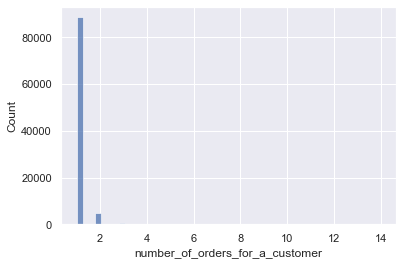

In [78]:
sns.histplot(data = new_df_for_segmentation_analysis, x = 'number_of_orders_for_a_customer', bins=50)

In [79]:
new_df_for_segmentation_analysis['number_of_orders_for_a_customer'].describe()

count    94228.000000
mean         1.074012
std          0.362468
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: number_of_orders_for_a_customer, dtype: float64

In [80]:
new_df_for_segmentation_analysis['number_of_orders_for_a_customer'].median()

1.0

As we observed the median of the number of orders is 1.

In [81]:
new_df_for_segmentation_analysis['number_of_orders_for_a_customer'].mean()

1.0740119709640445

As we observed the mean of the number of orders is ~1.

In [82]:
new_df_for_segmentation_analysis[new_df_for_segmentation_analysis['number_of_orders_for_a_customer'] > 1].describe()

order_item_id  review_score_for_a_customer_order  zip_code_prefix  \
count    5695.000000                        5695.000000      5695.000000   
mean        1.216857                           4.228973     33821.660404   
std         0.700141                           1.248773     29819.997401   
min         1.000000                           1.000000      1005.000000   
25%         1.000000                           4.000000      9723.000000   
50%         1.000000                           5.000000     22775.000000   
75%         1.000000                           5.000000     52011.000000   
max        15.000000                           5.000000     99750.000000   

       customer_geolocation_latitude  customer_geolocation_longitude  \
count                    5695.000000                     5695.000000   
mean                      -21.596670                      -46.292672   
std                         5.090986                        3.933373   
min                       -33.690972                      -67.843457   
25%                       -23.590672                      -47.982867   
50%                       -22.949477                      -46.630412   
75%                       -20.635630                      -43.821270   
max                         2.808802                      -34.825319   

       payment_value_for_a_customer_order  number_of_orders_for_a_customer  
count                         5695.000000                      5695.000000  
mean                           143.573824                         2.224583  
std                            172.701848                         0.874628  
min                              0.000000                         2.000000  
25%                             57.740000                         2.000000  
50%                             99.430000                         2.000000  
75%                            169.870000                         2.000000  
max                           4950.340000                        14.000000

In [83]:
new_df_for_segmentation_analysis[new_df_for_segmentation_analysis['number_of_orders_for_a_customer'] > 2].describe()

order_item_id  review_score_for_a_customer_order  zip_code_prefix  \
count     727.000000                         727.000000       727.000000   
mean        1.290234                           4.451169     34661.093535   
std         0.823017                           1.029868     29484.862211   
min         1.000000                           1.000000      1239.000000   
25%         1.000000                           4.000000      9993.000000   
50%         1.000000                           5.000000     24230.000000   
75%         1.000000                           5.000000     55293.000000   
max         8.000000                           5.000000     97670.000000   

       customer_geolocation_latitude  customer_geolocation_longitude  \
count                     727.000000                      727.000000   
mean                      -21.375540                      -46.094124   
std                         5.596389                        4.171513   
min                       -31.754573                      -63.865050   
25%                       -23.617639                      -47.946607   
50%                       -22.930150                      -46.593817   
75%                       -20.367679                      -43.334464   
max                        -2.499473                      -34.835533   

       payment_value_for_a_customer_order  number_of_orders_for_a_customer  
count                          727.000000                       727.000000  
mean                           147.923989                         3.759285  
std                            167.953984                         1.815481  
min                              0.000000                         3.000000  
25%                             53.015000                         3.000000  
50%                             97.390000                         3.000000  
75%                            172.400000                         4.000000  
max                           1202.640000                        14.000000

As we observed 6% of the customers placed more than 1 order. Then 0.8% made more than 2 orders.

### Creation of number of items of an order

As pointed out before, since an order can have more than one item of the same product, we can perform some operations to obtain new variables. We need to obtain the number of items per order an add it as a column.

In [84]:
new_df_for_segmentation_analysis['max'] = new_df_for_segmentation_analysis.groupby('customer_unique_id')['order_item_id'].transform('max')

new_df_for_segmentation_analysis = new_df_for_segmentation_analysis.drop(columns=['order_item_id'])

new_df_for_segmentation_analysis.rename(columns={"max":"number_of_items_for_a_customer"},inplace=True)

In [85]:
new_df_for_segmentation_analysis[new_df_for_segmentation_analysis['order_id'] == '62073ec6b54b8e6322037fc0f3591ad3']

product_id                          order_id  \
75742  1eba879220bd0981a0e2fbab499ed4e1  62073ec6b54b8e6322037fc0f3591ad3   

                              review_id  review_score_for_a_customer_order  \
75742  b10a077c65ccd8cab33e94a06beb13fe                                  2   

       zip_code_prefix  customer_geolocation_latitude  \
75742            26460                     -22.677025   

       customer_geolocation_longitude                       customer_id  \
75742                      -43.596491  368f207cdc8f5c93a2b2a5d4cce96ba8   

                     customer_unique_id customer_city customer_state  \
75742  f9172a6495d46451776be8bc8e46032d        japeri             RJ   

      order_purchase_timestamp order_delivered_customer_date payment_type  \
75742      2018-04-02 12:22:06           2018-04-24 20:36:50  credit_card   

       payment_value_for_a_customer_order product_category_name_english  \
75742                             1316.14                        office   

       number_of_orders_for_a_customer  number_of_items_for_a_customer  
75742                                1                               7

<AxesSubplot:xlabel='number_of_items_for_a_customer', ylabel='Count'>

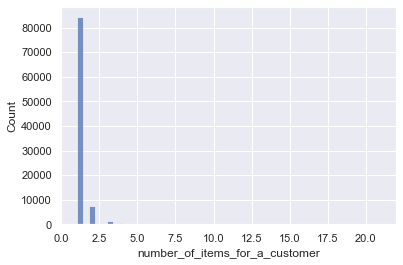

In [86]:
sns.histplot(data = new_df_for_segmentation_analysis, x = 'number_of_items_for_a_customer', bins=50)

In [87]:
new_df_for_segmentation_analysis['number_of_items_for_a_customer'].median()

1.0

In [88]:
new_df_for_segmentation_analysis['number_of_items_for_a_customer'].describe()

count    94228.000000
mean         1.152693
std          0.558876
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: number_of_items_for_a_customer, dtype: float64

In [89]:
new_df_for_segmentation_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94228 entries, 61236 to 112911
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   product_id                          94228 non-null  object 
 1   order_id                            94228 non-null  object 
 2   review_id                           94228 non-null  object 
 3   review_score_for_a_customer_order   94228 non-null  int64  
 4   zip_code_prefix                     94228 non-null  int64  
 5   customer_geolocation_latitude       94228 non-null  float64
 6   customer_geolocation_longitude      94228 non-null  float64
 7   customer_id                         94228 non-null  object 
 8   customer_unique_id                  94228 non-null  object 
 9   customer_city                       94228 non-null  object 
 10  customer_state                      94228 non-null  object 
 11  order_purchase_timestamp            

### Creation of a variable with delay of days purchase-delivery

We will get the number of days that passed from the purchase date to the delivery date.

In [90]:
new_df_for_segmentation_analysis['order_purchase_timestamp'] = pd.to_datetime(new_df_for_segmentation_analysis['order_purchase_timestamp']).dt.date

new_df_for_segmentation_analysis['order_delivered_customer_date'] = pd.to_datetime(new_df_for_segmentation_analysis['order_delivered_customer_date']).dt.date

In [91]:
new_df_for_segmentation_analysis['delay_days_purchase_delivery'] = (new_df_for_segmentation_analysis['order_purchase_timestamp'] \
                                                                    - new_df_for_segmentation_analysis['order_delivered_customer_date']).dt.days.abs()

In [92]:
new_df_for_segmentation_analysis.head()

product_id                          order_id  \
61236  79ce45dbc2ea29b22b5a261bbb7b7ee7  8272b63d03f5f79c56e9e4120aec44ef   
59093  ee3d532c8a438679776d222e997606b3  1b15974a0141d54e36626dca3fdc731a   
33154  89b190a046022486c635022524a974a8  428a2f660dc84138d969ccd69a0ab6d5   
73565  37eb69aca8718e843d897aa7b82f462d  9ef13efd6949e4573a18964dd1bbe7f5   
73115  422879e10f46682990de24d770e7f83d  73c8ab38f07dc94389065f7eba4f297a   

                              review_id  review_score_for_a_customer_order  \
61236  e8236fe7b6e1bdd513a500de361e2b87                                  1   
59093  be332150a9c96e68c9565ea53cba2355                                  1   
33154  d638a70f2be180ef55395eabb78fd88c                                  5   
73565  2e3a6e4930334530774ac3a6f6b62388                                  5   
73115  ee4bc8e340e8648a44c2e33fee6b27e4                                  1   

       zip_code_prefix  customer_geolocation_latitude  \
61236             5882                     -23.680171   
59093             3029                     -23.529755   
33154            84600                     -26.229883   
73565            74885                     -16.728165   
73115            11065                     -23.966109   

       customer_geolocation_longitude                       customer_id  \
61236                      -46.783830  fc3d1daec319d62d49bfb5e1f83123e9   
59093                      -46.617584  be1b70680b9f9694d8c70f41fa3dc92b   
33154                      -51.088864  10de381f8a8d23fff822753305f71cae   
73565                      -49.208647  adb32467ecc74b53576d9d13a5a55891   
73115                      -46.342984  d5f2b3f597c7ccafbb5cac0bcc3d6024   

                     customer_unique_id     customer_city customer_state  \
61236  4546caea018ad8c692964e3382debd19         sao paulo             SP   
59093  c402f431464c72e27330a67f7b94d4fb         sao paulo             SP   
33154  0f5ac8d5c31de21d2f25e24be15bbffb  uniao da vitoria             PR   
73565  11f97da02237a49c8e783dfda6f50e8e           goiania             GO   
73115  31e412b9fb766b6794724ed17a41dfa6            santos             SP   

      order_purchase_timestamp order_delivered_customer_date payment_type  \
61236               2017-07-16                    2017-07-31  credit_card   
59093               2018-02-22                    2018-03-05       boleto   
33154               2017-11-23                    2017-12-13  credit_card   
73565               2017-01-30                    2017-02-14  credit_card   
73115               2017-12-13                    2017-12-28       boleto   

       payment_value_for_a_customer_order product_category_name_english  \
61236                              196.11                 health_beauty   
59093                             2202.40                   electronics   
33154                             1225.65                          home   
73565                              783.00                   garden_pets   
73115                             1014.02                   garden_pets   

       number_of_orders_for_a_customer  number_of_items_for_a_customer  \
61236                                1                              21   
59093                                1                              20   
33154                                2                              15   
73565                                1                              15   
73115                                1                              14   

       delay_days_purchase_delivery  
61236                            15  
59093                            11  
33154                            20  
73565                            15  
73115                            15

In [93]:
new_df_for_segmentation_analysis['delay_days_purchase_delivery'].describe()

count    94228.000000
mean        12.443467
std          9.459214
min          0.000000
25%          7.000000
50%         10.000000
75%         16.000000
max        208.000000
Name: delay_days_purchase_delivery, dtype: float64

### Creation of a variable with customer-seller distance

In [94]:
new_df_for_segmentation_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94228 entries, 61236 to 112911
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   product_id                          94228 non-null  object 
 1   order_id                            94228 non-null  object 
 2   review_id                           94228 non-null  object 
 3   review_score_for_a_customer_order   94228 non-null  int64  
 4   zip_code_prefix                     94228 non-null  int64  
 5   customer_geolocation_latitude       94228 non-null  float64
 6   customer_geolocation_longitude      94228 non-null  float64
 7   customer_id                         94228 non-null  object 
 8   customer_unique_id                  94228 non-null  object 
 9   customer_city                       94228 non-null  object 
 10  customer_state                      94228 non-null  object 
 11  order_purchase_timestamp            

We will calculate the distance between customers and Olist building coordinates.

https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/

https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points

In [95]:
from math import *

# Olist location: See reference: https://www.addressschool.com/company/220256/olist
olist_lat = -25.43045
olist_lon = -49.29207

In [96]:
def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 6371 # radius of the earth (6371 km)
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [97]:
# Haversine distance between centre state and Olist office. Haversine distance is interpreted in kilometers

new_df_for_segmentation_analysis['olist_office_customer_distance'] = [haversine_distance(olist_lat, olist_lon, x, y) \
                                                                        for x, y in zip(new_df_for_segmentation_analysis.customer_geolocation_latitude, 
                                                                                        new_df_for_segmentation_analysis.customer_geolocation_longitude)]

In [98]:
new_df_for_segmentation_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94228 entries, 61236 to 112911
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   product_id                          94228 non-null  object 
 1   order_id                            94228 non-null  object 
 2   review_id                           94228 non-null  object 
 3   review_score_for_a_customer_order   94228 non-null  int64  
 4   zip_code_prefix                     94228 non-null  int64  
 5   customer_geolocation_latitude       94228 non-null  float64
 6   customer_geolocation_longitude      94228 non-null  float64
 7   customer_id                         94228 non-null  object 
 8   customer_unique_id                  94228 non-null  object 
 9   customer_city                       94228 non-null  object 
 10  customer_state                      94228 non-null  object 
 11  order_purchase_timestamp            

In [99]:
new_df_for_segmentation_analysis.head()

product_id                          order_id  \
61236  79ce45dbc2ea29b22b5a261bbb7b7ee7  8272b63d03f5f79c56e9e4120aec44ef   
59093  ee3d532c8a438679776d222e997606b3  1b15974a0141d54e36626dca3fdc731a   
33154  89b190a046022486c635022524a974a8  428a2f660dc84138d969ccd69a0ab6d5   
73565  37eb69aca8718e843d897aa7b82f462d  9ef13efd6949e4573a18964dd1bbe7f5   
73115  422879e10f46682990de24d770e7f83d  73c8ab38f07dc94389065f7eba4f297a   

                              review_id  review_score_for_a_customer_order  \
61236  e8236fe7b6e1bdd513a500de361e2b87                                  1   
59093  be332150a9c96e68c9565ea53cba2355                                  1   
33154  d638a70f2be180ef55395eabb78fd88c                                  5   
73565  2e3a6e4930334530774ac3a6f6b62388                                  5   
73115  ee4bc8e340e8648a44c2e33fee6b27e4                                  1   

       zip_code_prefix  customer_geolocation_latitude  \
61236             5882                     -23.680171   
59093             3029                     -23.529755   
33154            84600                     -26.229883   
73565            74885                     -16.728165   
73115            11065                     -23.966109   

       customer_geolocation_longitude                       customer_id  \
61236                      -46.783830  fc3d1daec319d62d49bfb5e1f83123e9   
59093                      -46.617584  be1b70680b9f9694d8c70f41fa3dc92b   
33154                      -51.088864  10de381f8a8d23fff822753305f71cae   
73565                      -49.208647  adb32467ecc74b53576d9d13a5a55891   
73115                      -46.342984  d5f2b3f597c7ccafbb5cac0bcc3d6024   

                     customer_unique_id     customer_city customer_state  \
61236  4546caea018ad8c692964e3382debd19         sao paulo             SP   
59093  c402f431464c72e27330a67f7b94d4fb         sao paulo             SP   
33154  0f5ac8d5c31de21d2f25e24be15bbffb  uniao da vitoria             PR   
73565  11f97da02237a49c8e783dfda6f50e8e           goiania             GO   
73115  31e412b9fb766b6794724ed17a41dfa6            santos             SP   

      order_purchase_timestamp order_delivered_customer_date payment_type  \
61236               2017-07-16                    2017-07-31  credit_card   
59093               2018-02-22                    2018-03-05       boleto   
33154               2017-11-23                    2017-12-13  credit_card   
73565               2017-01-30                    2017-02-14  credit_card   
73115               2017-12-13                    2017-12-28       boleto   

       payment_value_for_a_customer_order product_category_name_english  \
61236                              196.11                 health_beauty   
59093                             2202.40                   electronics   
33154                             1225.65                          home   
73565                              783.00                   garden_pets   
73115                             1014.02                   garden_pets   

       number_of_orders_for_a_customer  number_of_items_for_a_customer  \
61236                                1                              21   
59093                                1                              20   
33154                                2                              15   
73565                                1                              15   
73115                                1                              14   

       delay_days_purchase_delivery  olist_office_customer_distance  
61236                            15                      319.720579  
59093                            11                      343.378906  
33154                            20                      200.600056  
73565                            15                      967.688544  
73115                            15                      339.500844

In [100]:
new_df_for_segmentation_analysis['olist_office_customer_distance'].describe()

count    94228.000000
mean       717.591356
std        611.303698
min          0.661641
25%        340.892288
50%        495.149493
75%        818.129962
max       8594.471535
Name: olist_office_customer_distance, dtype: float64

## Visualization of some of the indicators

As follows, we will visualize some of the numerical variables distributions.

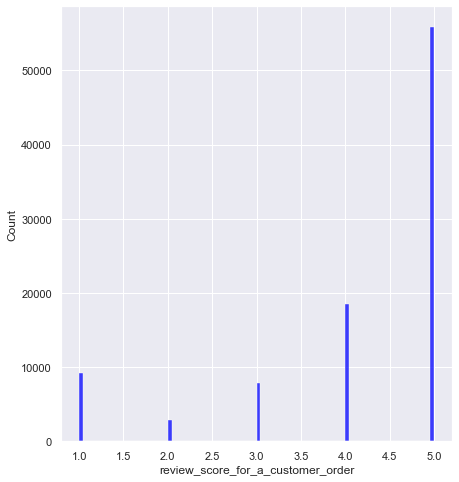

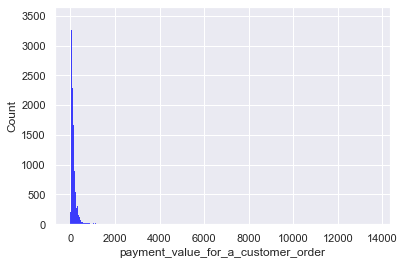

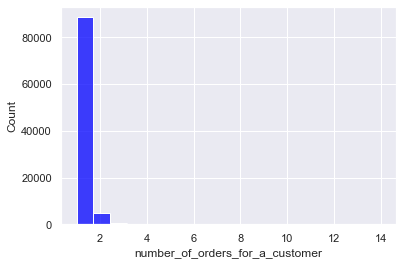

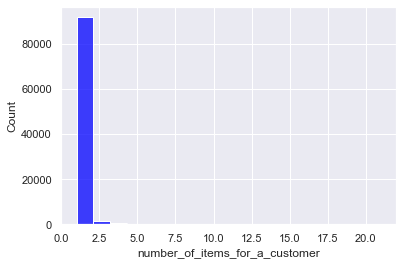

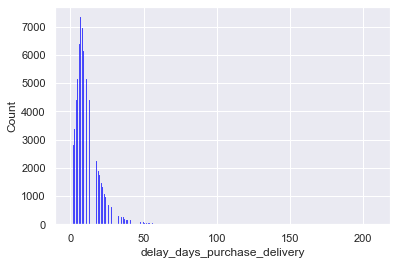

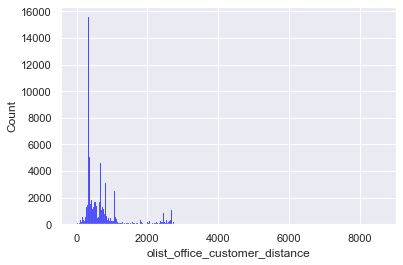

In [101]:
plt.subplots(figsize=(7, 8))

columns_histogram=['number_of_items_for_a_customer', 
                    'payment_value_for_a_customer_order', 
                    'review_score_for_a_customer_order', 
                    'number_of_orders_for_a_customer', 
                    'delay_days_purchase_delivery',
                    'olist_office_customer_distance']

for i in new_df_for_segmentation_analysis.columns:
    if i in columns_histogram:
        sns.histplot(data=new_df_for_segmentation_analysis, x=i, color="blue")
        plt.show()

In [102]:
new_df_for_segmentation_analysis['review_score_for_a_customer_order'].describe()

count    94228.000000
mean         4.157448
std          1.283207
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score_for_a_customer_order, dtype: float64

In [103]:
new_df_for_segmentation_analysis['payment_value_for_a_customer_order'].describe()

count    94228.000000
mean       157.112458
std        215.286394
min          0.000000
25%         60.010000
50%        103.005000
75%        174.802500
max      13664.080000
Name: payment_value_for_a_customer_order, dtype: float64

<AxesSubplot:xlabel='count', ylabel='product_category_name_english'>

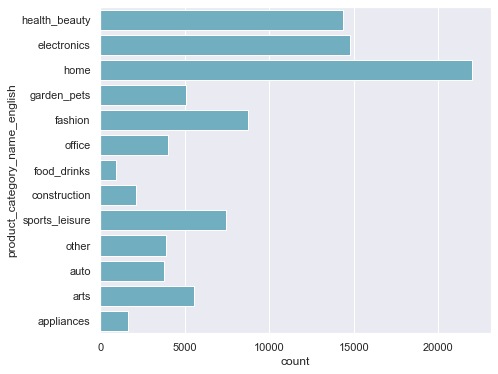

In [104]:
plt.subplots(figsize=(7, 6))
sns.countplot(y="product_category_name_english", data=new_df_for_segmentation_analysis, color="c")

<AxesSubplot:xlabel='count', ylabel='payment_type'>

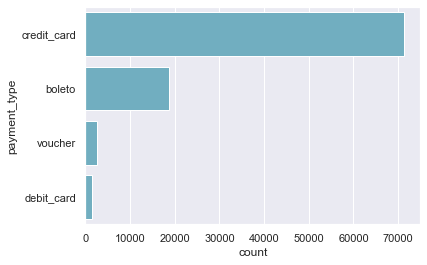

In [105]:
sns.countplot(y="payment_type", data=new_df_for_segmentation_analysis, color="c")

<AxesSubplot:xlabel='count', ylabel='customer_city'>

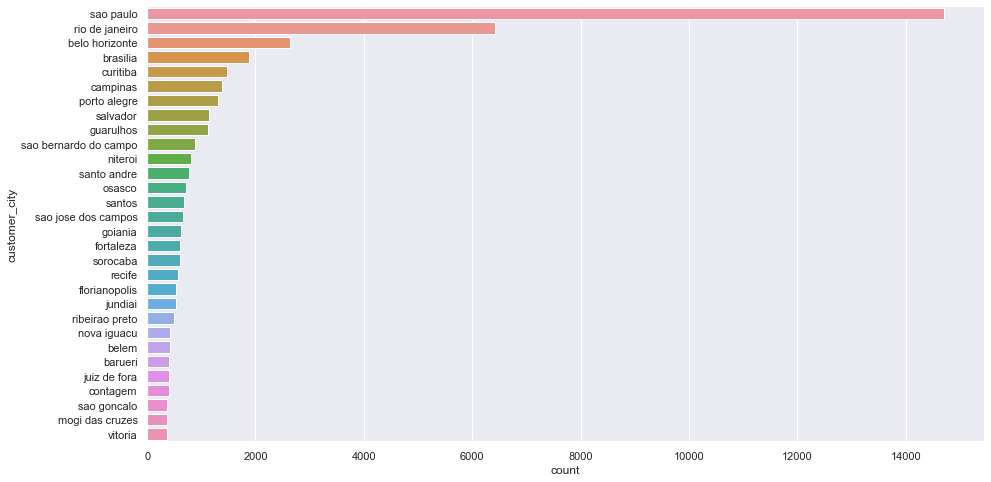

In [106]:
plt.figure(figsize=(15,8))
sns.countplot(y='customer_city', 
                data=new_df_for_segmentation_analysis, 
                order=new_df_for_segmentation_analysis['customer_city'].value_counts().iloc[:30].index)

In [107]:
new_df_for_segmentation_analysis['customer_city'].describe()

count         94228
unique         4028
top       sao paulo
freq          14712
Name: customer_city, dtype: object

<AxesSubplot:xlabel='count', ylabel='customer_state'>

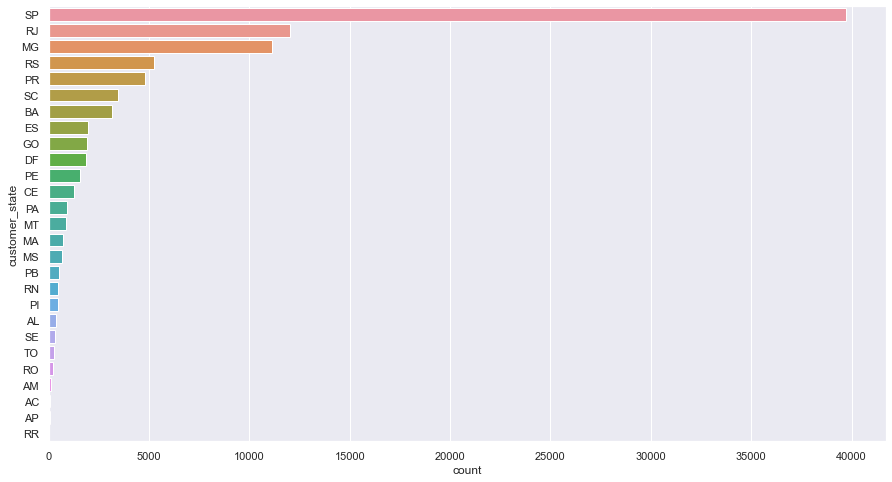

In [108]:
plt.figure(figsize=(15,8))
sns.countplot(y='customer_state', 
                data=new_df_for_segmentation_analysis, 
                order=new_df_for_segmentation_analysis['customer_state'].value_counts().iloc[:30].index)

In [109]:
new_df_for_segmentation_analysis['customer_state'].unique()

array(['SP', 'PR', 'GO', 'SC', 'MG', 'BA', 'RJ', 'RS', 'CE', 'PB', 'MT',
       'DF', 'TO', 'MS', 'AC', 'ES', 'MA', 'RO', 'AP', 'PE', 'SE', 'PI',
       'RN', 'AL', 'AM', 'PA', 'RR'], dtype=object)

## Base for the cluster maintenance analysis in time

We will analyse now how is the purche afluence in time according to the purchase timestamp variable. Fot this we will create a new dataframe that will contain the order purchase date, the order id and customer unique id for further purposes.

In [110]:
df_subset_for_purchase_dates = new_df_for_segmentation_analysis.copy()

In [111]:
columns_for_df_subset_for_purchase_dates = ['customer_unique_id', 'order_id', 'order_purchase_timestamp']

In [112]:
df_subset_for_purchase_dates = df_subset_for_purchase_dates[columns_for_df_subset_for_purchase_dates]
df_subset_for_purchase_dates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94228 entries, 61236 to 112911
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_unique_id        94228 non-null  object
 1   order_id                  94228 non-null  object
 2   order_purchase_timestamp  94228 non-null  object
dtypes: object(3)
memory usage: 4.9+ MB


We will now visualize the number of orders placed in time according to the order purchase timestamp from the dataset.

In [113]:
orders_per_days = df_subset_for_purchase_dates.groupby(df_subset_for_purchase_dates["order_purchase_timestamp"].\
                    astype('datetime64[ns]').dt.date).count()["order_id"]

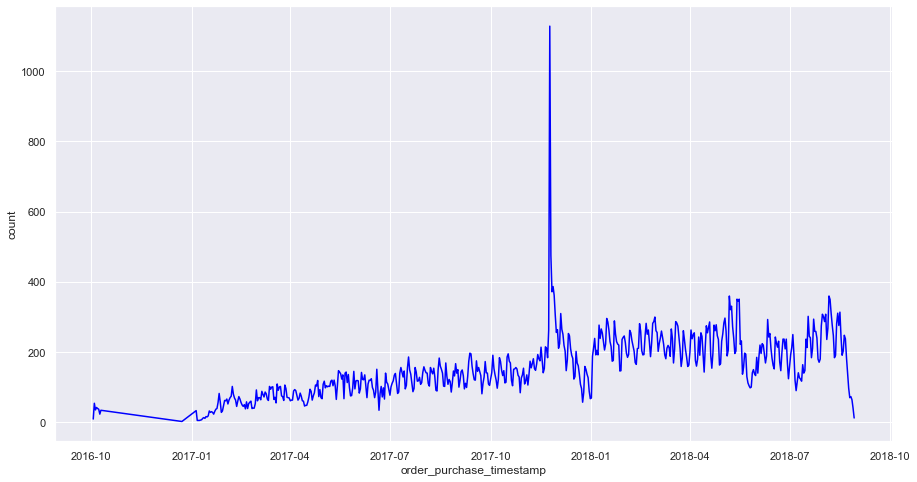

In [114]:
fig = plt.figure(figsize=(15, 8))
ax = orders_per_days.plot(color="blue")
ax.set_ylabel("count")

plt.show()

We observed an specific peak of order placements at the end of the year 2017, between November and December of 2017, and then a soft tendency of increase of orders afluence or sells in comparison with the begining of 2017.

Next, we will visualize the afluence of sells per month in the dataset. For this we will add a column dedicated to the month corresponding to the order purchase timestamp. It is importan to remark that such column will help us to visualize the month that has the higher number of orders within the three years of the dataset.

In [115]:
df_subset_for_purchase_dates['order_purchase_timestamp'] = df_subset_for_purchase_dates['order_purchase_timestamp'].\
                                                            astype('datetime64[ns]')

In [116]:
df_subset_for_purchase_dates.head()

customer_unique_id                          order_id  \
61236  4546caea018ad8c692964e3382debd19  8272b63d03f5f79c56e9e4120aec44ef   
59093  c402f431464c72e27330a67f7b94d4fb  1b15974a0141d54e36626dca3fdc731a   
33154  0f5ac8d5c31de21d2f25e24be15bbffb  428a2f660dc84138d969ccd69a0ab6d5   
73565  11f97da02237a49c8e783dfda6f50e8e  9ef13efd6949e4573a18964dd1bbe7f5   
73115  31e412b9fb766b6794724ed17a41dfa6  73c8ab38f07dc94389065f7eba4f297a   

      order_purchase_timestamp  
61236               2017-07-16  
59093               2018-02-22  
33154               2017-11-23  
73565               2017-01-30  
73115               2017-12-13

In [117]:
df_subset_for_purchase_dates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94228 entries, 61236 to 112911
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        94228 non-null  object        
 1   order_id                  94228 non-null  object        
 2   order_purchase_timestamp  94228 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 4.9+ MB


In [118]:
df_subset_for_purchase_dates['date_month'] = [x.month for x in df_subset_for_purchase_dates['order_purchase_timestamp'].tolist()]

df_subset_for_purchase_dates['purchase_month'] = \
    df_subset_for_purchase_dates['date_month'].map({1: 'January',
                                                            2: 'February',
                                                            3: 'March',
                                                            4: 'April',
                                                            5: 'May',
                                                            6: 'June',
                                                            7: 'July',
                                                            8: 'August',
                                                            9: 'September',
                                                            10: 'October',
                                                            11: 'November',
                                                            12: 'December'})

df_subset_for_purchase_dates = df_subset_for_purchase_dates.drop(columns=['date_month'])

df_subset_for_purchase_dates.head()

customer_unique_id                          order_id  \
61236  4546caea018ad8c692964e3382debd19  8272b63d03f5f79c56e9e4120aec44ef   
59093  c402f431464c72e27330a67f7b94d4fb  1b15974a0141d54e36626dca3fdc731a   
33154  0f5ac8d5c31de21d2f25e24be15bbffb  428a2f660dc84138d969ccd69a0ab6d5   
73565  11f97da02237a49c8e783dfda6f50e8e  9ef13efd6949e4573a18964dd1bbe7f5   
73115  31e412b9fb766b6794724ed17a41dfa6  73c8ab38f07dc94389065f7eba4f297a   

      order_purchase_timestamp purchase_month  
61236               2017-07-16           July  
59093               2018-02-22       February  
33154               2017-11-23       November  
73565               2017-01-30        January  
73115               2017-12-13       December

<AxesSubplot:xlabel='count', ylabel='purchase_month'>

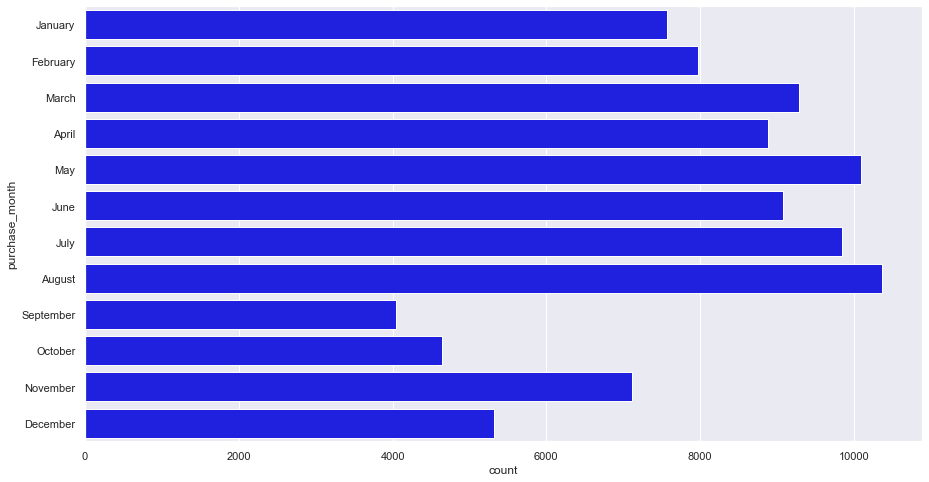

In [119]:
fig = plt.figure(figsize=(15, 8))
Months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
sns.countplot(y="purchase_month", data=df_subset_for_purchase_dates, order=Months, color="blue")

According to the previous graph, the month with more placed orders in the complete data is August. 

For a more detailed visualization, we could extract the data corresponding to 2018, which was the year that registered ascending sells and determine the month with more sells. 

We could also extract the data from september 2017 and september 2018, which could also let us explore the clients loyalty in a one year period.

## Pickling dataframe

Pickle is used for serializing and de-serializing Python object structures, also called marshalling or flattening. Serialization refers to the process of converting an object in memory to a byte stream that can be stored on disk or sent over a network. Later on, this character stream can then be retrieved and de-serialized back to a Python object. For more details, consult references:

In [120]:
# To pickle the dataframe

new_df_for_segmentation_analysis.to_pickle("./pickle_dataset_merged.pkl")

df_subset_for_purchase_dates.to_pickle("./pickle_dataset_time_analysis.pkl")